Using spaCy and NLTK along with a Bag of Words approach, automated the process of combing through FOMC minutes transcripts to determine sentiment over time and to understand its fed funds predictabilty.

In [ ]:
!pip install BeautifulSoup4
!pip install lxml
!pip install html5lib
!pip install nltk==3.2.5
!pip install pdfplumber
!pip install -U spacy
!python -m spacy download en


In [11]:
import pandas as pd
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from collections import Counter
from nltk.corpus import stopwords
import pdfplumber
from datetime import datetime 
import datetime as dt

import urllib
import urllib.request
from bs4 import BeautifulSoup
from bs4 import re
import requests
import re

import spacy
from html import unescape
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# create a spaCy tokenizer

spacy.load('en')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nlp = spacy.lang.en.English()
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
all_stopwords |= {'the','is','th','s', 'm','would'}

# remove html entities from docs and set everything to lowercase
def my_preprocessor(doc):
  return(unescape(doc).lower())

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    
    text = word_tokenize(doc)
    tokens_without_sw= [word for word in text if not word in all_stopwords]
    
    return tokens_without_sw

In [4]:
def preprocess_tokens(tokens):
  '''
  Remove any extra lines, non-letter characters, and blank quotes
  '''
  remove_new_lines = [re.sub('\s+', '', token) for token in tokens] 
  #Remove non letter characters
  non_letters = [re.sub('[^a-zA-Z]', '', remove_new_line) for remove_new_line in remove_new_lines]
  #Remove distracting single quotes
  remove_quotes = [re.sub("\'", '', non_letter) for non_letter in non_letters]
  #Removes empty strings from a list of strings
  final = list(filter(None, remove_quotes)) 
  
  return final

In [5]:
def concat_text(text):
    x=''
    for i in text:
        x = x+i
    return x

def get_text(path):  #file is the path
  docs = []
  with pdfplumber.open(path) as pdf:
    for i in range(len(pdf.pages)):
      page = pdf.pages[i]   
      text = page.extract_text()
      docs.append(text)
    concat = concat_text(docs)
  return concat
  
def get_words(full_text):

  raw = [word.lower() for word in full_text.split()]
 
  values = ','.join(map(str, raw))  #converts bytes object to string
  tokenizer = my_tokenizer(values)
 
  words = preprocess_tokens(tokenizer)
  # remove stopwords
  stops = nltk.corpus.stopwords.words('english')
  new_stopwords = ['chairman','would', 'mr']
  stops.extend(new_stopwords)
  words = [word for word in words if word not in stops]
  counter = Counter()
  counter.update(words)
  most_common = counter.most_common(25) 

  return words, most_common


In [ ]:
#testing pdf extraction

link = '/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/feddata/2009/FOMC20090812meeting.pdf'
link2 = '/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/feddata/1980/FOMC19800109meeting.pdf'
link3 = '/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/feddata/2009/FOMC20090128meeting.pdf'

text = (get_text(link3))


In [ ]:
len(text)
# print(text)

472348

### Grab all the files and extract the text from the pdf

In [6]:
#Pull the files

# generates a dictionary of transcript paths
# if we already have the pdf data, set path_to_local_pdf to True. 
link_to_file_on_website = False
path_to_local_pdf = True

if link_to_file_on_website:
    base_url = "https://www.federalreserve.gov/monetarypolicy/"
if path_to_local_pdf or path_to_local_txt:
    base_directory = "/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/feddata/"
    
transcript_links = {}
for year in range(1980, 2010): 
    
    if link_to_file_on_website:
        path = "fomchistorical" + str(year) + ".htm"
        html_doc = requests.get(base_url + path)
        soup = BeautifulSoup(html_doc.content, 'html.parser')
        links = soup.find_all("a", string=re.compile('Transcript .*'))
        link_base_url = "https://www.federalreserve.gov"
        transcript_links[str(year)] = [link_base_url + link["href"] for link in links]
        
    elif path_to_local_pdf or path_to_local_txt:
        files = []
        path_to_folder = base_directory + str(year)
        new_files = os.walk(path_to_folder)
        for file in new_files:
            for f in file[2]:
                if path_to_local_pdf:
                    if f[-11:] == "meeting.pdf":
                      files.append(str(file[0]) + "/" + f)
        transcript_links[str(year)] = files
    print("Year Complete: ", year)

Year Complete:  1980
Year Complete:  1981
Year Complete:  1982
Year Complete:  1983
Year Complete:  1984
Year Complete:  1985
Year Complete:  1986
Year Complete:  1987
Year Complete:  1988
Year Complete:  1989
Year Complete:  1990
Year Complete:  1991
Year Complete:  1992
Year Complete:  1993
Year Complete:  1994
Year Complete:  1995
Year Complete:  1996
Year Complete:  1997
Year Complete:  1998
Year Complete:  1999
Year Complete:  2000
Year Complete:  2001
Year Complete:  2002
Year Complete:  2003
Year Complete:  2004
Year Complete:  2005
Year Complete:  2006
Year Complete:  2007
Year Complete:  2008
Year Complete:  2009


In [ ]:
Dates, transcripts, all_words, top_tokens = [],[],[],[]

#transcript_links contains every pdf in each year
for year in transcript_links: #produces the year index folder 

  if int(year)<2010:continue
  # if int(year) == 2010: break #test out one decade - opted to end study at 2010

  for file in transcript_links[year]:  #the file in each year folder
    print(file)
    text = get_text(file)
    words = get_words(text)
    
    #Append datapoints to respective lists
    Dates.append(datetime.strptime(file[-19:-11], '%Y%m%d').date())
    transcripts.append(text)  #all pages?
    all_words.append(words[0])  #returns all words in the document
    top_tokens.append(words[1]) #tuple of words with their respective counts in that document
 
#Formatting data in to dataframe
Data = pd.DataFrame([Dates,transcripts, all_words, top_tokens]).T
Data.columns =['Date','Transcript','all_words', 'top_tokens']
Data.set_index('Date', inplace= True)
Data.sort_index(inplace=True)


In [8]:
# Data80_90 = Data.copy()
# Data00s = Data.copy()
# Data05s = Data.copy()
# Data10s = Data.copy()

# Data80_90.head()

# retrieve = pd.concat([Data, Data05s], sort=False)
# retrieve.tail()

# Data05s.head()


,Transcript,all_words,top_tokens
Date,,,
2005-02-02,"February 1-2, 2005 1 of 177\n \nMeeting of the...","[february, meeting, federal, open, market, com...","[(inflation, 420), (think, 300), (rate, 172), ..."
2005-03-22,"March 22, 2005 1 of 116\n \n \n \n \nMeeting o...","[march, meeting, federal, open, market, commit...","[(think, 181), (inflation, 179), (prices, 129)..."
2005-05-03,"May 3, 2005 1 of 116\nMeeting of the Federal O...","[may, meeting, federal, open, market, committe...","[(think, 205), (inflation, 180), (prices, 143)..."
2005-06-30,"June 29-30, 2005 1 of 234\n \n \nMeeting of th...","[june, meeting, federal, open, market, committ...","[(prices, 363), (percent, 233), (policy, 218),..."
2005-08-09,"August 9, 2005 1 of 110\n \n \n \nMeeting of t...","[august, meeting, federal, open, market, commi...","[(inflation, 186), (think, 142), (rate, 127), ..."


In [ ]:
# Data = pd.concat([Data80_90, Data00s], sort=False)

Data.tail()
Data.shape

(204, 3)

In [ ]:
#save our dataset down for later analysis

Data.to_csv('/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/fomc_transcript_tokens', header=True)

To preserve the exact structure of the DataFrame, an easy solution 
is to serialize the DF in pickle format with pd.to_pickle, instead 
of using csv, which will always throw away all information about data types, 
and will require manual reconstruction after re-import. One drawback of pickle is 
that it's not human-readable.
repr() and ast.literal_eval(); for just lists, tuples and integers since 
the csv format converts everything to string.

In [7]:
from ast import literal_eval  

#reload our transcript tokens csv
Data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/fomc_transcript_tokens')

# Data['Transcript'] = Data['Transcript'].apply(literal_eval)
Data['all_words'] = Data['all_words'].apply(literal_eval)
Data['top_tokens'] = Data['top_tokens'].apply(literal_eval)
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')
Data.set_index("Date", inplace = True)


In [9]:
Data.index

DatetimeIndex(['1980-01-09', '1980-02-05', '1980-03-18', '1980-04-22',
               '1980-05-20', '1980-07-09', '1980-08-12', '1980-09-16',
               '1980-10-21', '1980-11-18',
               ...
               '2008-10-29', '2008-12-16', '2009-01-28', '2009-03-18',
               '2009-04-29', '2009-06-24', '2009-08-12', '2009-09-23',
               '2009-11-04', '2009-12-16'],
              dtype='datetime64[ns]', name='Date', length=244, freq=None)

In [8]:

#Count the total word frequency across all transcripts
word_df = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(Data)):  #total links
  word_count = {'Words':[],'Count':[]}
  for sets in Data['top_tokens'][i]:
    # print(files)  #total pairs
    word_count['Words'].append(sets[0])  #total words broken out
    word_count['Count'].append(sets[1])  #total count per word
    
  word_df1 = pd.DataFrame(word_count)
  word_df = word_df.append(word_df1, ignore_index=True)

total_words = word_df.groupby(['Words']).sum()
sorted_top_words = total_words.sort_values(by='Count', ascending=False)
sorted_top_words=sorted_top_words[:25]

In [9]:
sorted_top_words

,Count
Words,
think,53559
rate,28526
percent,28278
going,24328
inflation,24289
growth,23915
market,18307
year,17935
greenspan,16373


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

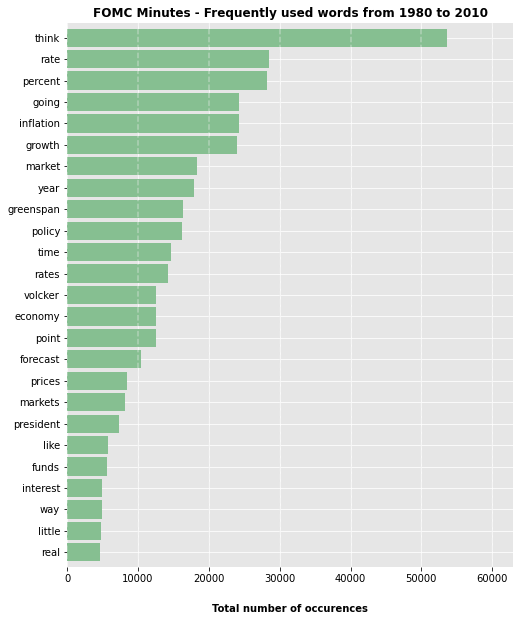

In [12]:
import matplotlib.pyplot as plt

sorted_top_words = sorted_top_words.sort_values(by="Count")


plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
              axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

ax = sorted_top_words.plot(kind='barh', figsize=(8, 10), color='#86bf91', width=0.85);

ax.get_legend().remove()
plt.title("FOMC Minutes - Frequently used words from 1980 to 2010",fontsize=12, weight='bold')
# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels

ax.yaxis.label.set_visible(False)
ax.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

plt.savefig('fomc_top_words.png',dpi=60, bbox_inches = "tight")
files.download('fomc_top_words.png');



Build a dictionary:  Applying a sentiment analysis to the words in the documents using the Loughran-McDonald context-specific lexicon, which assigns a simple positive or negative value to words based on the financial services industry context

In [13]:
#Create a matrix of word types and the words that match these types
word_list = []
for sentiment_class in ["Negative", "Positive", "Uncertainty",
                       "StrongModal", "WeakModal", "Constraining"]:
    sentiment_list = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Projects/FOMC_NLP/LM Word List.xlsx", sheet_name=sentiment_class,header=None)
    sentiment_list.columns = [sentiment_class]
    sentiment_list[sentiment_class] = sentiment_list[sentiment_class].str.lower()
    word_list.append(sentiment_list)
word_list = pd.concat(word_list, axis=1, sort=True).fillna(" ")
print(word_list.head())
word_list = word_list.to_dict('list')  #create a dictionary out of the excel list and use it to map the transcripts
print(word_list)

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

       Negative    Positive  Uncertainty   StrongModal   WeakModal Constraining
0       abandon        able     abeyance        always      almost        abide
1     abandoned   abundance    abeyances          best  apparently      abiding
2    abandoning    abundant       almost       clearly    appeared        bound
3   abandonment   acclaimed   alteration    definitely   appearing      bounded
4  abandonments  accomplish  alterations  definitively     appears       commit
{'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated', 'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational', 'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish', 'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating', 'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences', 'absenteeism', 'abuse', 'abused', 'abu

In [14]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [15]:
def tone_count_with_negation_check(fin_dict, transcript):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []

    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', transcript.lower())
 
    word_count = len(input_words)
  

    for i in range(0, word_count):
      if input_words[i] in fin_dict['Negative']:
       
        neg_count += 1
        neg_words.append(input_words[i])
      if input_words[i] in fin_dict['Positive']:
        if i >= 3:
          if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
            neg_count += 1
            neg_words.append(input_words[i] + ' (with negation)')
          else:
            pos_count += 1
            pos_words.append(input_words[i])
        elif i == 2:
          if negated(input_words[i - 1]) or negated(input_words[i - 2]):
            neg_count += 1
            neg_words.append(input_words[i] + ' (with negation)')
          else:
              pos_count += 1
              pos_words.append(input_words[i])
        elif i == 1:
          if negated(input_words[i - 1]):
                neg_count += 1
                neg_words.append(input_words[i] + ' (with negation)')
          else:
                pos_count += 1
                pos_words.append(input_words[i])
        elif i == 0:
              pos_count += 1
              pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [16]:
temp = [tone_count_with_negation_check(word_list,x) for x in Data.Transcript]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values
Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values

In [17]:
temp.head()

,0,1,2,3,4
0,45809,254,747,"[good, attain, desired, desired, achieve, good...","[perils, lagged, error, shortfall, decline, la..."
1,40201,267,775,"[better, strong, adequately, benefit, desirabl...","[lagged, lag, opposed, problems, lapse, lagged..."
2,24418,140,417,"[great, strong, strong, able, despite, good, p...","[dispose, late, contrary, objection, closed, o..."
3,21605,121,427,"[delighted, successfully, stabilize, pleased, ...","[objection, questions, declining, declines, we..."
4,24794,149,417,"[good, strong, good, better, strong, progress,...","[objection, questions, decline, question, weak..."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

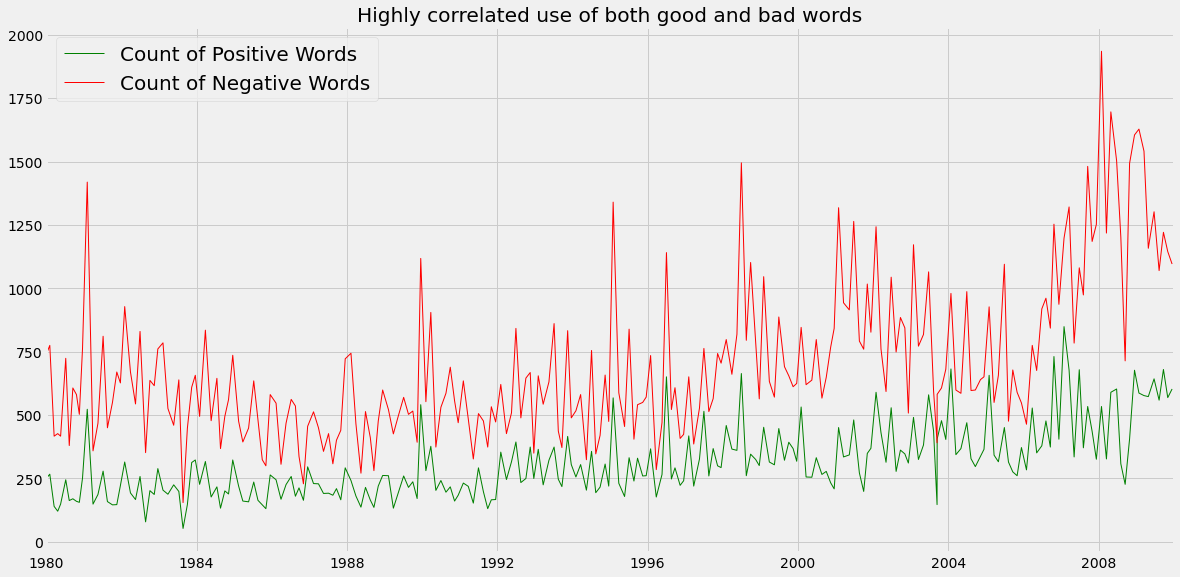

In [18]:
import numpy as np
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax.plot(Data.index, Data['NPositiveWords'], 
         c = 'green',
         linewidth= 1.0)

plt.plot(Data.index, Data['NNegativeWords'], 
         c = 'red',
         linewidth=1.0)

plt.title('Highly correlated use of both good and bad words')

plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 20},
           loc = 2
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.savefig('fomc_correlated_words.png',dpi=60, bbox_inches = "tight")
files.download('fomc_correlated_words.png');

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

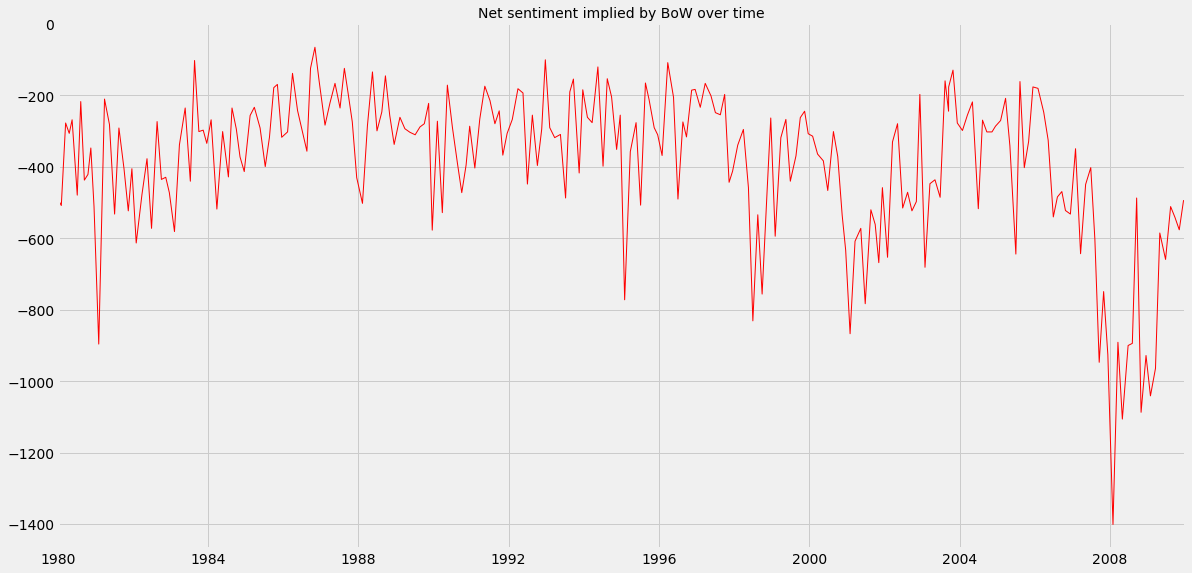

In [19]:

NetSentiment = (Data['NPositiveWords'] - Data['NNegativeWords'])

fig, ax = plt.subplots()

ax.plot(Data.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.savefig('fomc_net_sentiment.png',dpi=60, bbox_inches = "tight")
files.download('fomc_net_sentiment.png');

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

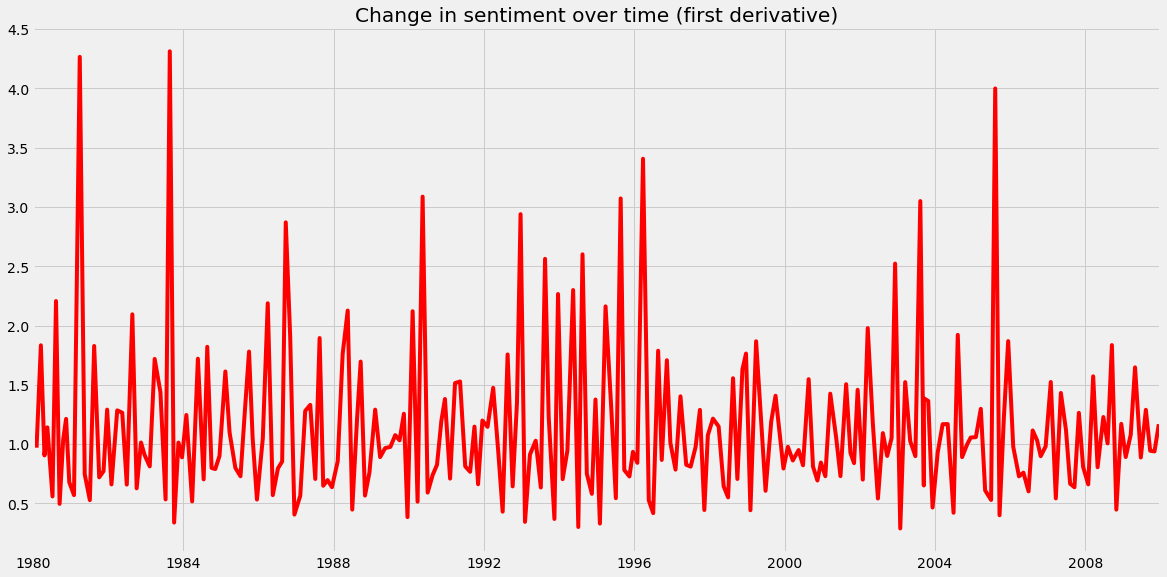

In [20]:
firstderivative = (NetSentiment.shift(1) / NetSentiment)

fig, ax = plt.subplots()

ax.plot(Data.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.savefig('fomc_sentiment_chg.png',dpi=60, bbox_inches = "tight")
files.download('fomc_sentiment_chg.png');

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

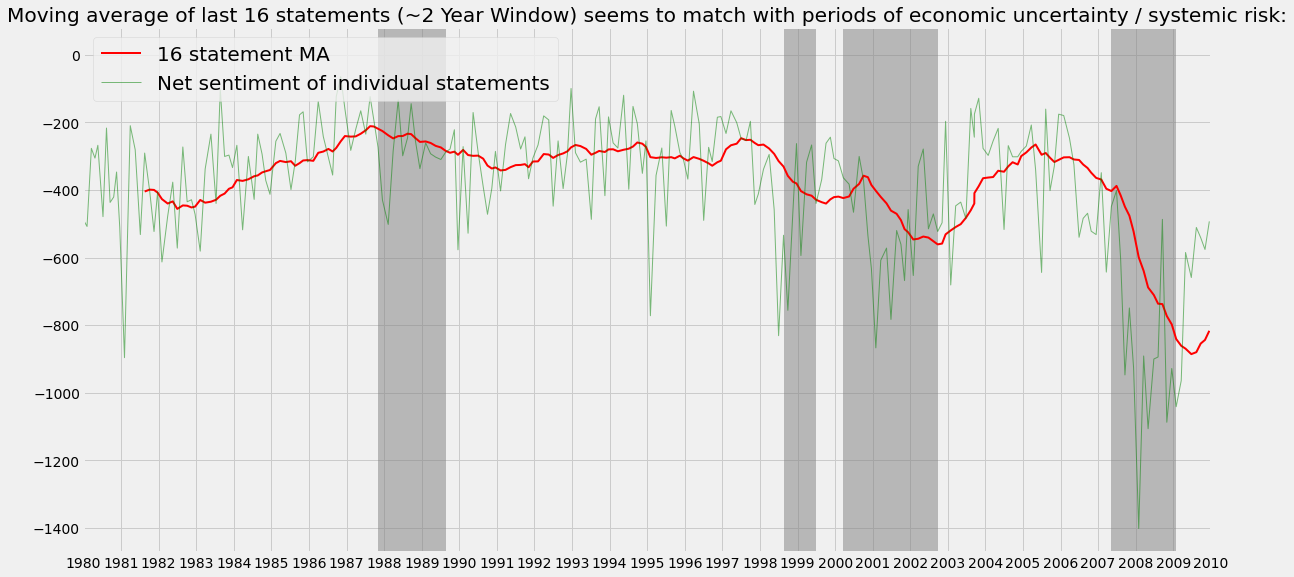

In [21]:
#Black Monday and the time period till US Equity market recovery
#https://en.wikipedia.org/wiki/Black_Monday_(1987)
BlkMonday = np.logical_and(Data.index > '1987-10',
                          Data.index < '1989-09'
                          )

#1998–1999 Russian Ruble crisis
#https://en.wikipedia.org/wiki/1998_Russian_financial_crisis
Russian = np.logical_and(Data.index > '1998-08',
                       Data.index < '1999-08'
                       )

#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(Data.index > '2000-03',
                         Data.index < '2002-10'
                        )

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
Credit = np.logical_and(Data.index > '2007-04',
                         Data.index < '2009-03'
                        )


Recessions = np.logical_or.reduce( ( BlkMonday,
                                     Russian,
                                    DotCom,
                                     Credit
                                    )
                                 )

Window = 16
CompToMA = NetSentiment.rolling(Window).mean()

fig, ax = plt.subplots()
ax.plot(Data.index,
         CompToMA,
         c = 'r',
         linewidth= 2)

ax.plot(Data.index, NetSentiment, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty / systemic risk:'))

ax.legend([str(str(Window) + ' statement MA'), 'Net sentiment of individual statements'],
           prop={'size': 20},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Recessions,
                facecolor='grey', alpha=0.5, transform=trans)

plt.savefig('fomc_crisis_periods.png',dpi=60, bbox_inches = "tight")
files.download('fomc_crisis_periods.png');
plt.show()
